In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from collections import defaultdict
from exps_nn import DiffRobHPScore_o_cf

# Dummy scorer function
def crappy_scorer(x, lambda_):
    # Simulates a scoring function based on input dict x and lambda
    return x["value"] * lambda_ + x.get("bias", 0)

def plot_all_score_subplots(d1, d2, lambdas, scorer, subplot_shape=(2, 2)):
    assert d1.keys() == d2.keys(), "d1 and d2 must have the same keys"
    keys = list(d1.keys())
    assert 0 <= len(keys) <= 4, "There must be at most 4 keys to fit in a 2x2 grid"

    fig, axes = plt.subplots(*subplot_shape, figsize=(6 * subplot_shape[1], 5 * subplot_shape[0]))
    axes = axes.flatten()

    for i, n in enumerate(keys):
        ax = axes[i]
        data = []

        for lambda_ in lambdas:
            scores1 = [scorer(x, lambda_) for x in d1[n]]
            scores2 = [scorer(x, lambda_) for x in d2[n]]
            data.extend([
                {"lambda": lambda_, "score": s, "group": "d1"} for s in scores1
            ])
            data.extend([
                {"lambda": lambda_, "score": s, "group": "d2"} for s in scores2
            ])

        import pandas as pd
        df = pd.DataFrame(data)

        sns.violinplot(data=df, x="lambda", y="score", hue="group", ax=ax, split=True)
        ax.set_title(f"Number of nodes = {n}")
        ax.legend(title="Dataset")

    plt.tight_layout()
    plt.show()


def plot_all_time_subplots(d1, d2):
    assert d1.keys() == d2.keys(), "d1 and d2 must have the same keys"
    keys = list(d1.keys())
    assert 0 <= len(keys) <= 4, "There must be at most 4 keys to fit in a 2x2 grid"

    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    
    data = []
    for i, n in enumerate(keys):
        times1 = [x['time'] for x in d1[n]]
        times2 = [x['time'] for x in d2[n]]
        data.extend([
            {"num_nodes": n, "time": t, "group": "Ordinary HP"} for t in times1
        ])
        data.extend([
            {"num_nodes": n, "time": t, "group": "Diffrentiable HP"} for t in times2
        ])

        import pandas as pd
        df = pd.DataFrame(data)

    sns.violinplot(data=df, x="num_nodes", y="time", hue="group", split=True)
    # if not original_lambdas:
    #     ax.set_xticks([])           # Removes tick marks
    #     ax.set_xticklabels([])      # Removes tick labels
    #     ax.set_xlabel("")           # Removes x-axis label
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"Time")
    ax.legend(title="Dataset")

    plt.tight_layout()
    plt.show()

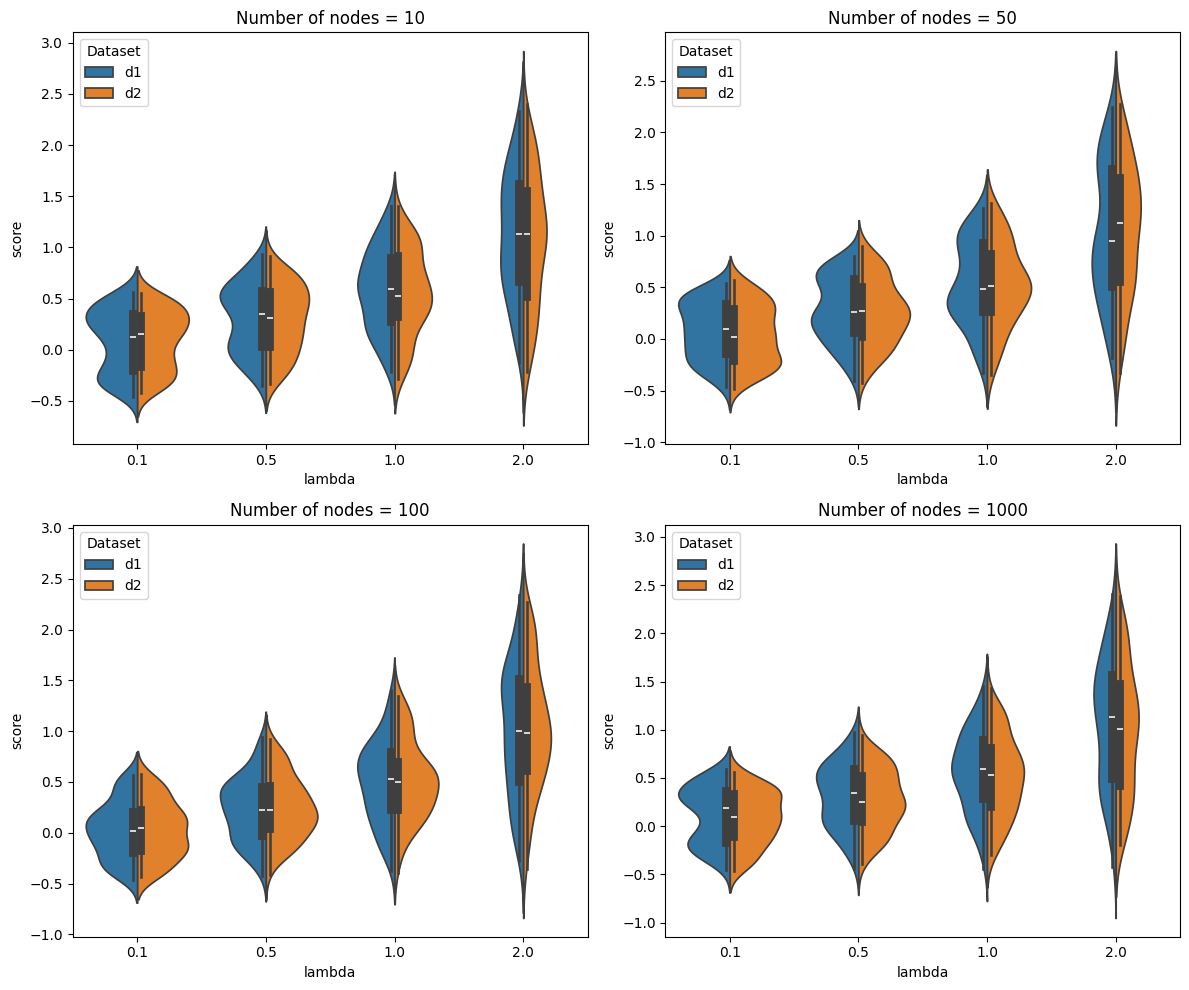

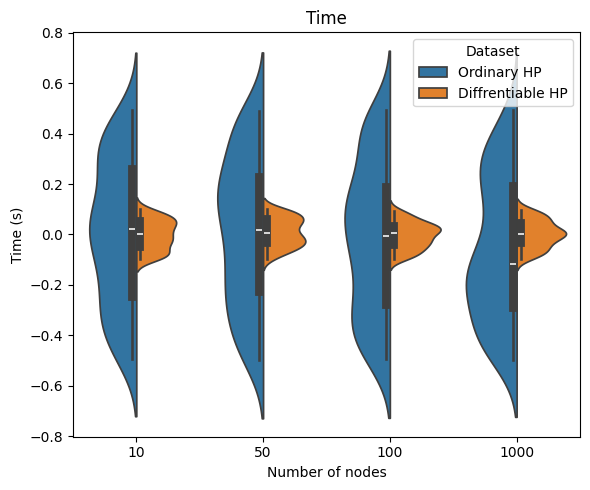

In [53]:
# --- Test Case ---
def generate_test_data():
    keys = [10, 50, 100, 1000]
    d1 = {}
    d2 = {}

    for k in keys:
        d1[k] = [{"value": random.uniform(0, 1), "bias": random.uniform(-0.5, 0.5), "time": random.uniform(-0.5, 0.5)} for _ in range(100)]
        d2[k] = [{"value": random.uniform(0, 1), "bias": random.uniform(-0.5, 0.5), "time": random.uniform(-0.1, 0.1)} for _ in range(100)]

    return d1, d2

# Example usage
d1, d2 = generate_test_data()
lambdas = [0.1, 0.5, 1.0, 2.0]
plot_all_score_subplots(d1, d2, lambdas, crappy_scorer, subplot_shape=(2, 2))
plot_all_time_subplots(d1, d2)


In [37]:
import pickle
with open("results/results_20250505_193231.pkl", "rb") as f:
    data = pickle.load(f)
    print(data[10][0])

{'adj': array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-3,  0,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -2,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -2,  3,  0,  0,  4,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  4,  0, -3,  0,  0,  0],
       [ 0,  0,  3,  4,  0,  4,  0,  0,  0,  0]]), 'u': array([-0.66666667,  0.        ,  0.        ,  2.        ,  0.        ,
        0.        ,  0.        ,  0.        , 25.33333333,  0.        ]), 'v': array([   0.57142857,   -1.71428571,   -0.57142857,    0.        ,
         -4.        ,   16.        ,    0.57142857,   49.71428571,
       -162.28571429,  101.71428571]), 'o': np.float64(16.0), 'a_cause_hp': {'cf_X': {0: 0.25}, 'W': {8: 10.66666666666667, 2: -1.333333333333333, 3: 0.0}, 'o': np.float64(15.999999999999996), 'o_cf': 5.6111111

In [82]:
d1 = defaultdict(list)
d2 = defaultdict(list)
for n, v in data.items():
    for i, x in enumerate(v):
        d1[n].append({"time": x["delta_hp"], "cause": x["a_cause_hp"]})
        d2[n].append({"time": x["delta_hp_nn"], "cause": x["a_cause_hp_nn"]})

In [86]:
# FIXME: load from above pickle
o_func = lambda v: sum(v)**2 + v[3]**2 + v[4]**2 
n = 10

import torch
import numpy as np

def DiffRobHPScoreWrapper(x, lambda_):
    x = x['cause']
    n = 10  # or dynamically infer from data if needed

    pW = np.zeros(n)
    pW[list(x['W'].keys())] = list(x['W'].values())

    pX = np.zeros(n)
    pX[list(x['cf_X'].keys())] = list(x['cf_X'].values())

    x_prime = np.zeros(n)
    x_prime[list(x['cf_X'].keys())] = list(x['cf_X'].values())

    # Convert to torch tensors
    pW = torch.tensor(pW, dtype=torch.float32)
    pX = torch.tensor(pX, dtype=torch.float32)
    x_prime = torch.tensor(x_prime, dtype=torch.float32)

    o_cf = x['o_cf']
    if isinstance(o_cf, np.generic):  # ensure native Python float
        o_cf = float(o_cf)

    ans = float(DiffRobHPScore_o_cf(pW, pX, x_prime, o_cf, l1=0, l2=lambda_, l3=lambda_))
    return ans


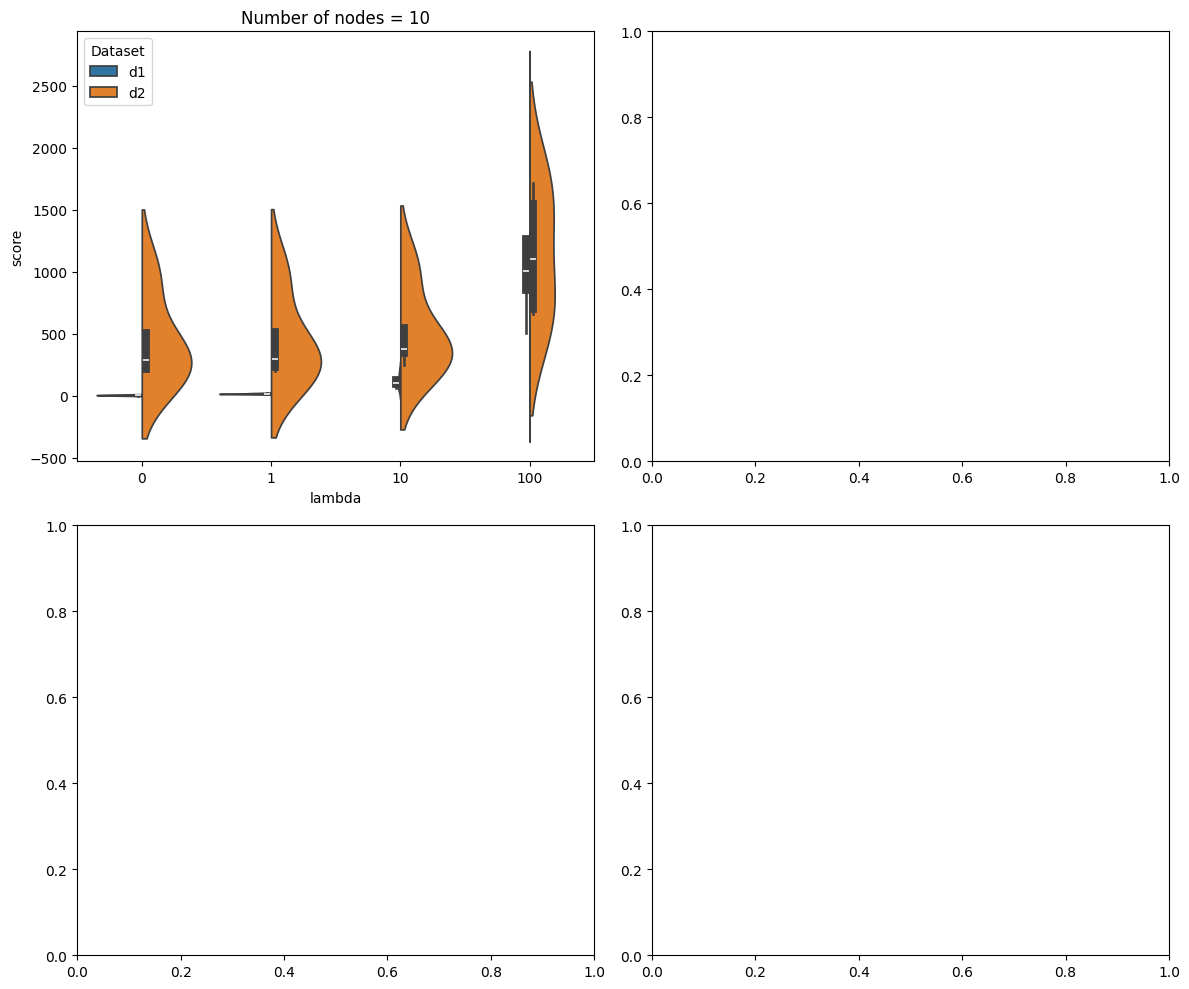

In [89]:
plot_all_score_subplots(d1, d2, [0, 1, 10, 100], DiffRobHPScoreWrapper, subplot_shape=(2, 2))

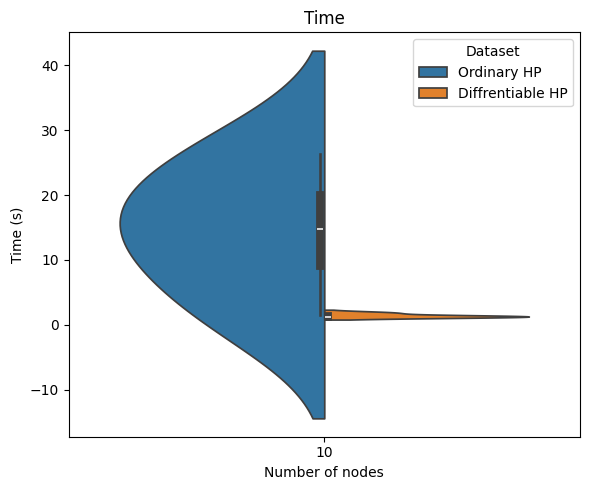

In [70]:
plot_all_time_subplots(d1, d2)